# Linear Regression

In [1]:
# Imports
import pandas as pd
import numpy as np
import joblib
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Preprocessing
from transformers import AverageTransformer, DateTransformer, CyclicalTransformer, SimpleDateTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler, QuantileTransformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_theme(style='ticks', palette='viridis', rc={"axes.spines.right": False, "axes.spines.top": False})

In [4]:
# Data
X = pd.read_csv('data/train.csv')
y = X['TARGET_energy']
X.drop(columns=['TARGET_energy'], inplace=True)
X.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-02-20 13:20:00,21.530000,45.096667,20.600000,40.500000,21.474,42.40,18.323333,46.10,17.600000,54.264286,9.963333,92.656667,17.70,39.663333,20.650000,47.895000,17.70,44.200000,9.500000,755.000000,92.000000,5.333333,32.666667,8.200000,48.717990,48.717990
1,2016-01-23 06:20:00,17.290000,43.200000,16.356667,43.290000,17.700,41.20,15.300000,42.53,15.533333,48.961111,6.466667,99.900000,15.69,38.090000,16.655556,45.971667,15.19,42.433333,5.900000,766.866667,99.666667,4.000000,19.000000,5.833333,42.204855,42.204855
2,2016-04-02 09:50:00,20.890000,39.400000,18.790000,42.700000,21.790,37.40,19.790000,38.40,19.290000,45.090000,10.566667,37.993333,19.89,33.900000,21.200000,39.590000,19.60,37.730000,7.600000,757.983333,82.500000,1.833333,64.000000,4.716667,40.133645,40.133645
3,2016-02-07 12:40:00,21.133333,44.500000,20.500000,42.156667,21.500,43.59,18.790000,43.20,19.055556,59.102222,8.926667,64.193333,18.79,37.637778,20.890000,46.850556,19.10,44.933333,8.133333,745.966667,73.333333,8.333333,40.000000,3.533333,24.570344,24.570344
4,2016-04-21 19:50:00,23.000000,37.163333,22.500000,35.363333,23.200,36.40,22.890000,34.29,20.790000,41.290000,16.430000,1.000000,22.20,32.441429,23.000000,38.463333,20.20,35.730000,15.783333,759.516667,54.666667,4.000000,40.000000,6.566667,18.195913,18.195913


## Evaluation Framework
Root Mean Squared Error will give use residual errors measured in the same unit as the target feature, making it easier to interpret. R squared informs us on how well the model explains the data variance. As RMSE is an error term, we are attempting to minimise it compared to R squared which is a score we are trying to maximise. 

In [5]:
# Metrics
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate

# Evaluation
from functions import residual_plots,feature_importance, learning_curves

# Scoring Metrics
rmse = make_scorer(mean_squared_error, squared=False,greater_is_better=False)
r2 = make_scorer(r2_score)

# DataFrame to hold cross validation results
cv_df = pd.DataFrame(columns=['model', 'average_rmse', 'average_r2'])

## Preprocessing

In [ ]:
# Drop redundant features
drop = ('drop', ['rv1', 'rv2'])

# Date Transformer
dt = (DateTransformer(['date']), ['date'])

# Scaler
ss = StandardScaler()

## Baseline Pipeline

In [6]:
# Baseline Pipeline
preprocess = make_column_transformer(drop, dt, remainder='passthrough')
model = LinearRegression()
pipeline = make_pipeline(preprocess, ss, model)
pipeline.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['rv1', 'rv2']),
                                                 ('datetransformer',
                                                  DateTransformer(date=['date']),
                                                  ['date'])])),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [7]:
cv = cross_validate(pipeline, X, y, cv=10, scoring=['neg_root_mean_squared_error', 'r2'])

mean_rmse = cv['test_neg_root_mean_squared_error'].mean()
mean_r2 = cv['test_r2'].mean()

cv_df.loc[cv_df.shape[0]] = (['baseline', mean_rmse, mean_r2])
cv_df

,model,average_rmse,average_r2
0,baseline,-92.508225,0.199379


In [8]:
print(f'average root mean squared error: {mean_rmse:.3f}')
print(f'average r squared: {mean_r2:.3f}')

average root mean squared error: -92.508
average r squared: 0.199


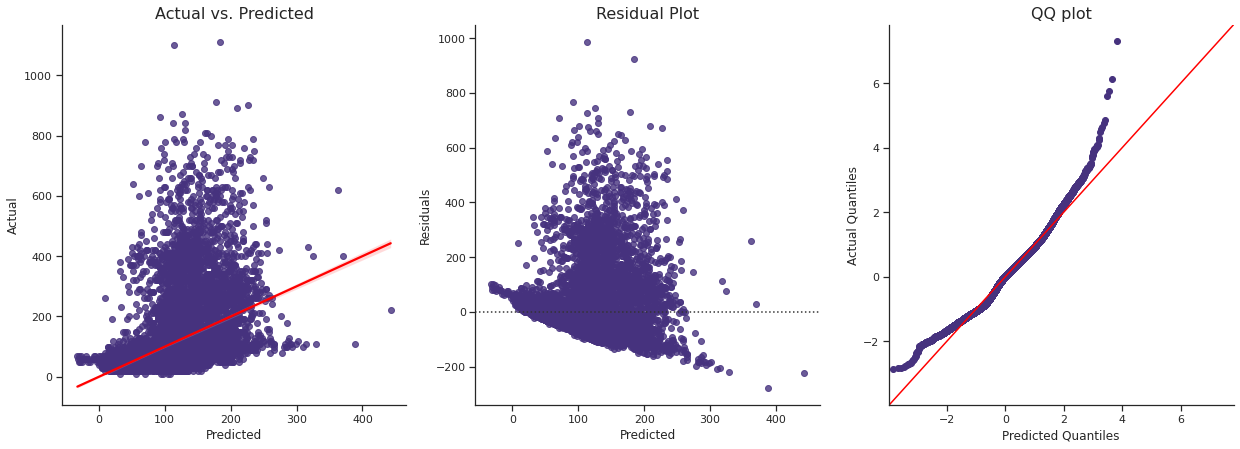

In [9]:
residual_plots(pipeline, X, y)

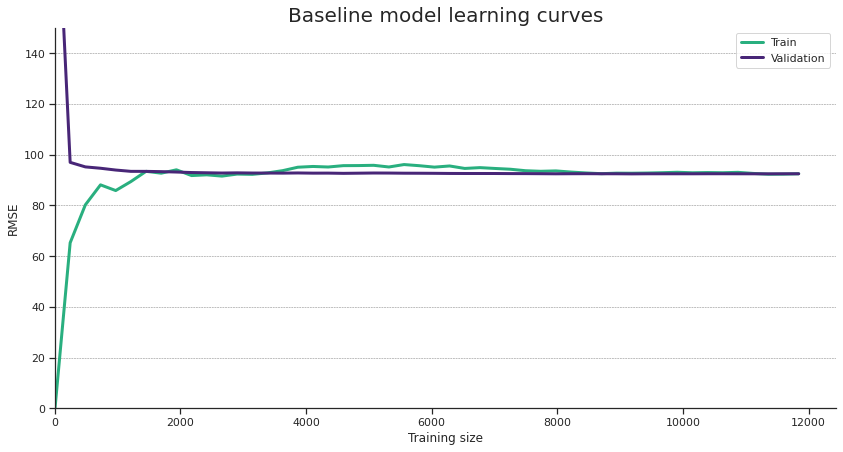

In [10]:
learning_curves(pipeline, X, y, 'Baseline model learning curves')

The q-q plot indicates that the model seems to underestimate values at both tails of the target feature distribution. This might indicate a few things, including the need for feature engineering and feature transformation to deal with unruly distributions, outliers and wide variance amongst features. It could also indicate that regularisation may help in future iterations.

The learning curve shows that the training and validation datasets eventually converge, with a high error rate. This indicates that the model could use more complexity, through feature engineering, adding extra features or using a different type of model.

Baseline linear regression optimises it's fit by minimising the ordinary least squares (OLS) error.

## Feature Engineering
#### 1. Transforming the target feature
The first thing we can try is to transform the target feature. We know from the exploratory data analysis that the distribution of the target feature seems to be on a logarithmic scale.

In [11]:
tt = TransformedTargetRegressor(regressor=pipeline, func=np.log, inverse_func=np.exp)

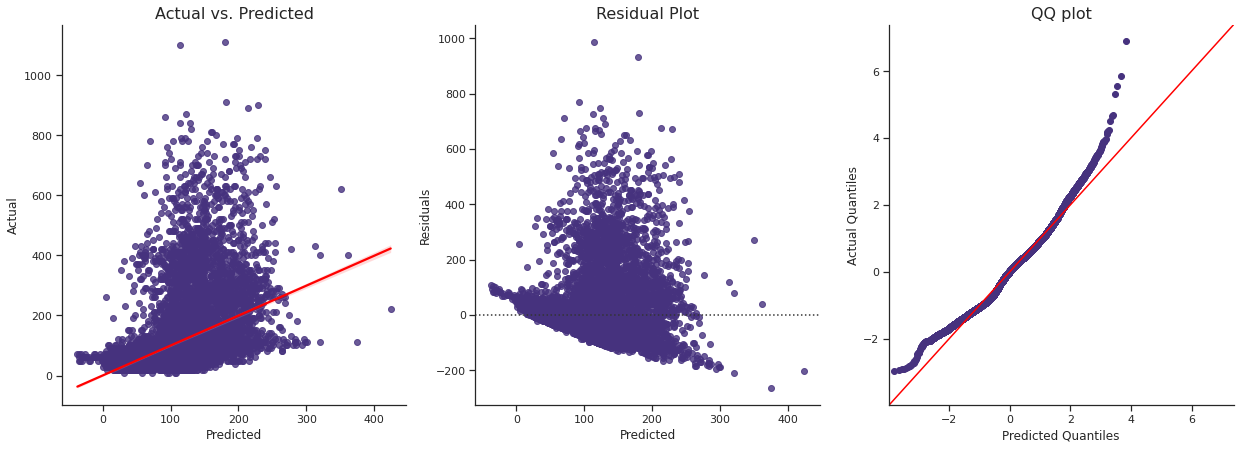

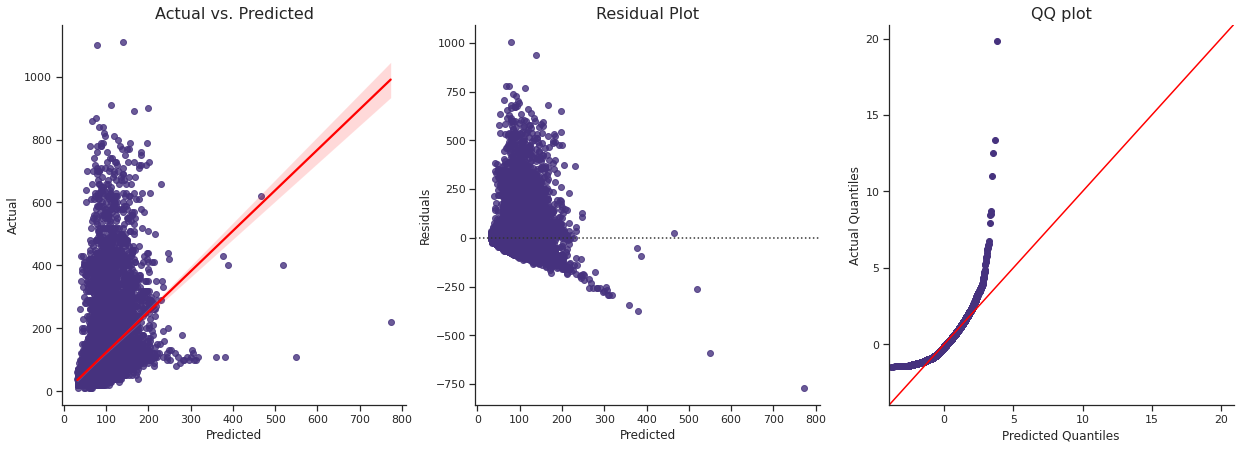

In [12]:
tt.fit(X,y)
residual_plots(pipeline, X, y)
residual_plots(tt, X, y)

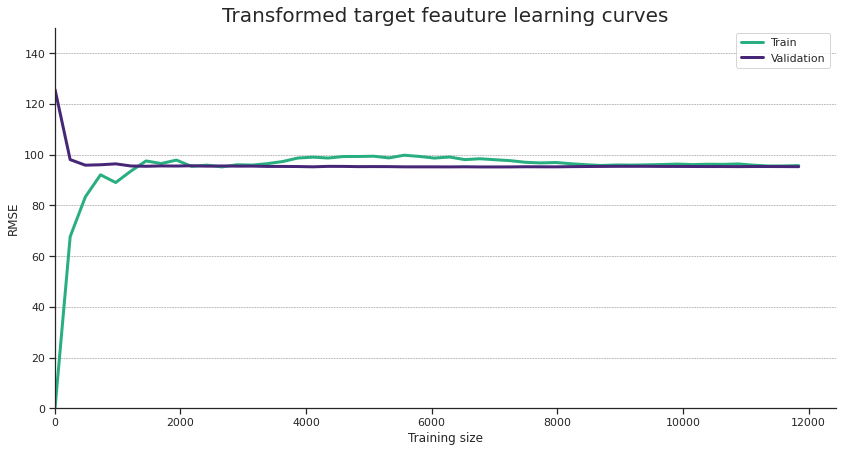

In [13]:
learning_curves(tt, X, y, 'Transformed target feauture learning curves')

In [14]:
cv = cross_validate(tt, X, y, cv=10, scoring=['neg_root_mean_squared_error', 'r2'])

mean_rmse = cv['test_neg_root_mean_squared_error'].mean()
mean_r2 = cv['test_r2'].mean()

cv_df.loc[cv_df.shape[0]] = (['transformed-target', mean_rmse, mean_r2])
cv_df

,model,average_rmse,average_r2
0,baseline,-92.508225,0.199379
1,transformed-target,-95.598424,0.145565


In [15]:
print(f'average root mean squared error: {mean_rmse:.3f}')
print(f'average r squared: {mean_r2:.3f}')

average root mean squared error: -95.598
average r squared: 0.146


That seems to have worsened the shape of the Q-Q plot and increased the RMSE. The heteroscedastic 'cone shaped' pattern, as well as the imbalance on the y-axis indicate that more feature and target feature engineering may be required in order to get better results. The patterns of the residual plots also indicate that the dataset may be better suited to non-linear regression models.

#### 2. Combining multicollinear features
During exploratory analysis, we found that temperature variables and humidity variables were highly collinear. Attempting to simplify these variables into singular variables may improve the model.

In [16]:
# Transformation Columns
T_cols = [col for col in X.columns if re.search('T\d', col)]
RH_cols = [col for col in X.columns if re.search('RH_[1-4,7-9]', col)]

# Transformers
t_at = (AverageTransformer(T_cols, ['T_avg']), T_cols)
rh_at = (AverageTransformer(RH_cols, ['RH_avg']), RH_cols)
drop_t_rh =('drop', T_cols + RH_cols)

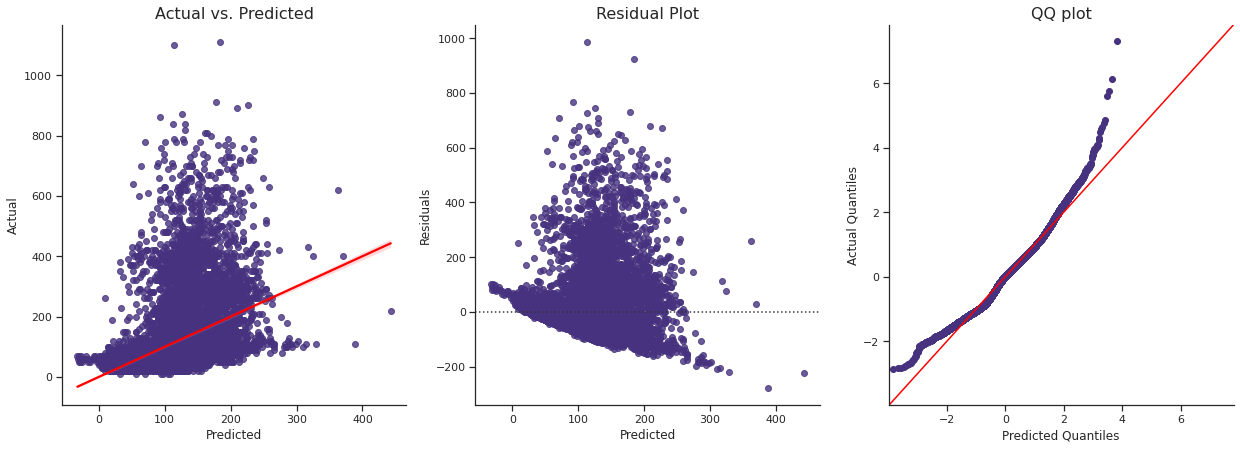

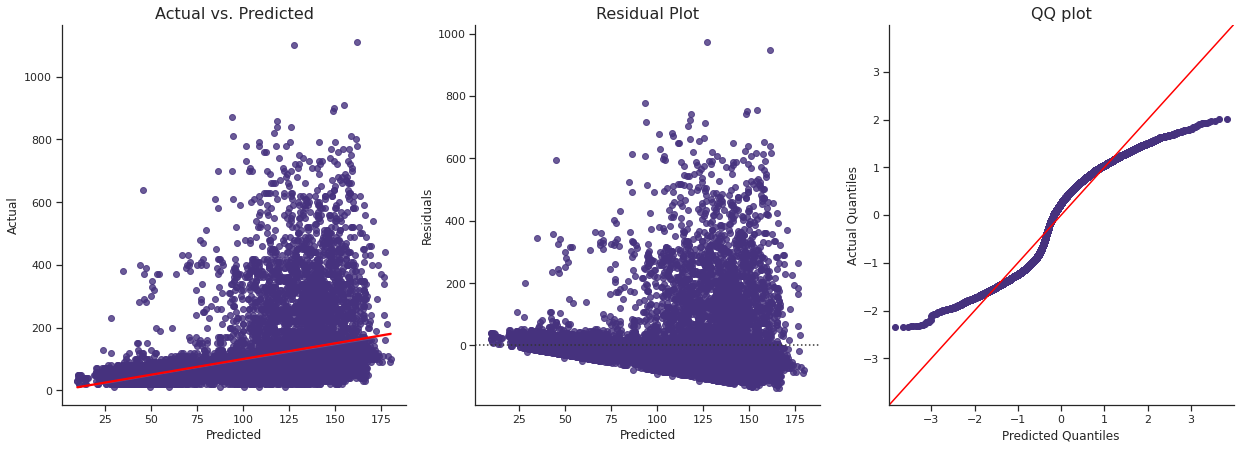

In [17]:
avg_preprocess = make_column_transformer(drop, t_at, rh_at, dt, drop_t_rh, remainder='passthrough')
avg_pipeline = make_pipeline(avg_preprocess, ss, model)

pipeline.fit(X,y)
residual_plots(pipeline, X, y)

avg_pipeline.fit(X,y)
residual_plots(avg_pipeline, X, y)

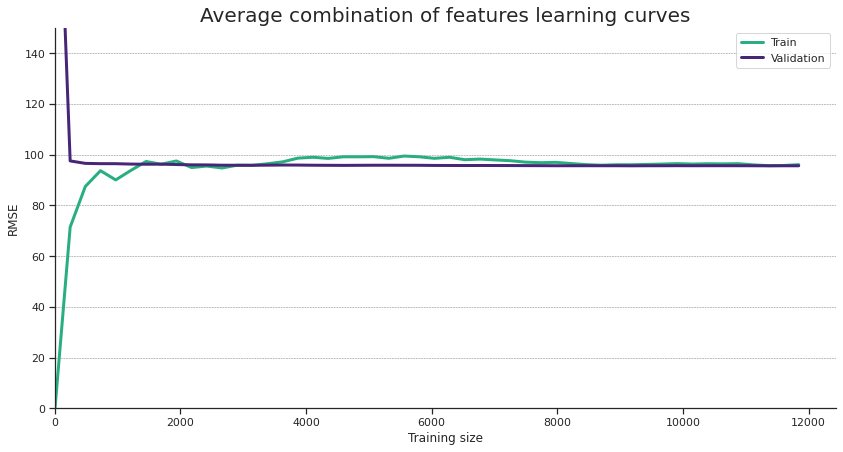

In [18]:
learning_curves(avg_pipeline, X, y, 'Average combination of features learning curves')

Combining features had no positive effect on the model, increasing the RMSE and increasing the variance of the residuals.

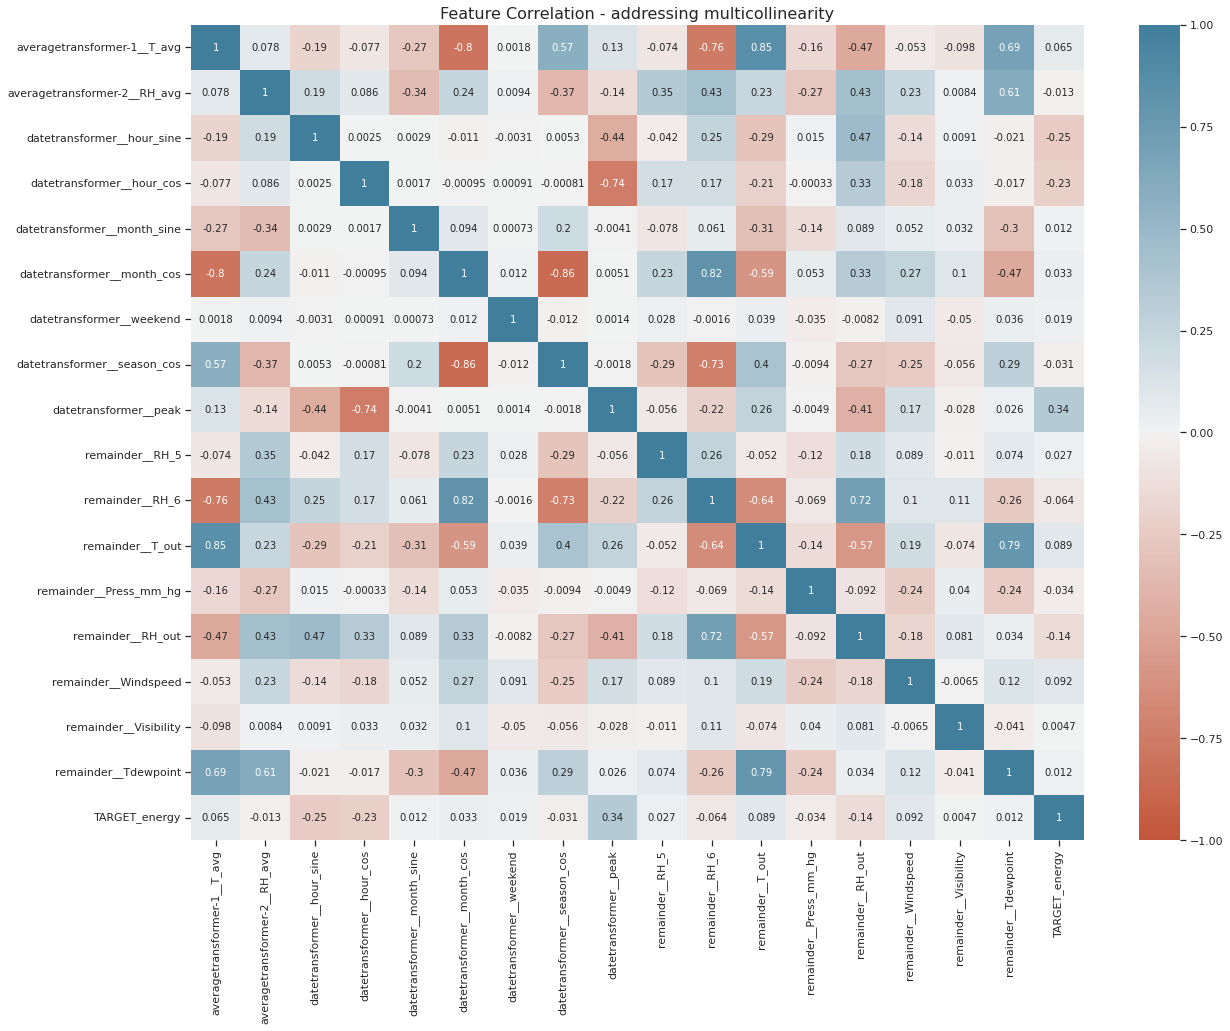

In [19]:
fig = plt.figure(figsize=(20,15))
cmap = sns.diverging_palette(20, 230, as_cmap=True)
df = pd.DataFrame(avg_preprocess.fit_transform(X,y), columns = avg_preprocess.get_feature_names_out())
df['TARGET_energy'] = y

corr = df.corr()
sns.heatmap(corr, annot=True, cmap=cmap, vmin=-1, vmax=1)

plt.title('Feature Correlation - addressing multicollinearity', fontsize=16)
plt.show()

In [20]:
cv = cross_validate(avg_pipeline, X, y, cv=10, scoring=['neg_root_mean_squared_error', 'r2'])

mean_rmse = cv['test_neg_root_mean_squared_error'].mean()
mean_r2 = cv['test_r2'].mean()

cv_df.loc[cv_df.shape[0]] = (['average-transform', mean_rmse, mean_r2])
cv_df

,model,average_rmse,average_r2
0,baseline,-92.508225,0.199379
1,transformed-target,-95.598424,0.145565
2,average-transform,-95.887430,0.139937


In [21]:
print(f'average root mean squared error: {mean_rmse:.3f}')
print(f'average r squared: {mean_r2:.3f}')

average root mean squared error: -95.887
average r squared: 0.140


#### 3. Scaling
As we observed in the exploratory data analysis, not all features are distributed normally. We can address this here by using a Power Transformer after transforming the relevant columns.

In [22]:
pt = PowerTransformer()
qt = QuantileTransformer()

preprocess = make_column_transformer(drop, dt, remainder='passthrough')
pt_pipeline = make_pipeline(preprocess, pt, model)
qt_pipeline = make_pipeline(preprocess, qt, model)

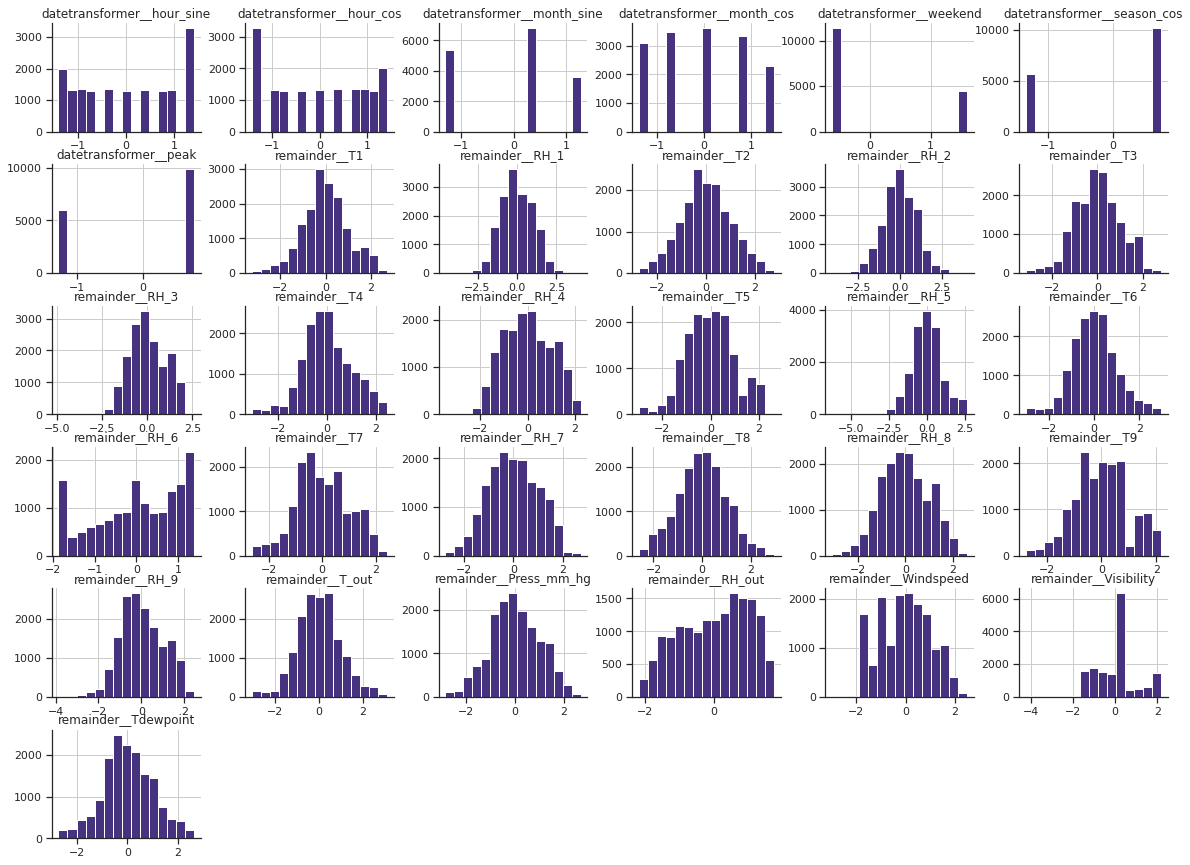

In [23]:
data = pt.fit_transform(preprocess.fit_transform(X,y), y)

pd.DataFrame(data, columns=preprocess.get_feature_names_out()).hist(bins=15, figsize=(20,15))
plt.title('Power Transformer applied to preprocessed features')
plt.show()

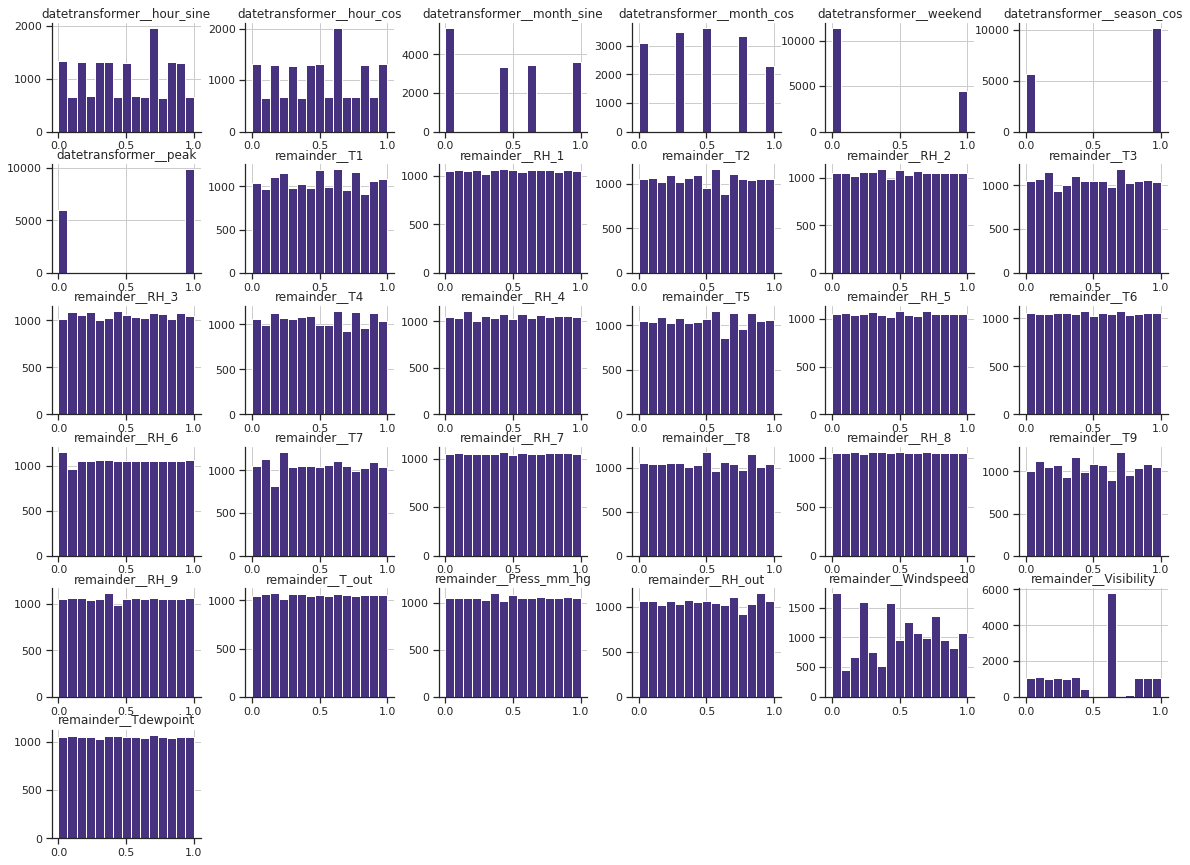

In [24]:
data = qt.fit_transform(preprocess.fit_transform(X,y), y)

pd.DataFrame(data, columns=preprocess.get_feature_names_out()).hist(bins=15, figsize=(20,15))
plt.title('Power Transformer applied to preprocessed features')
plt.show()

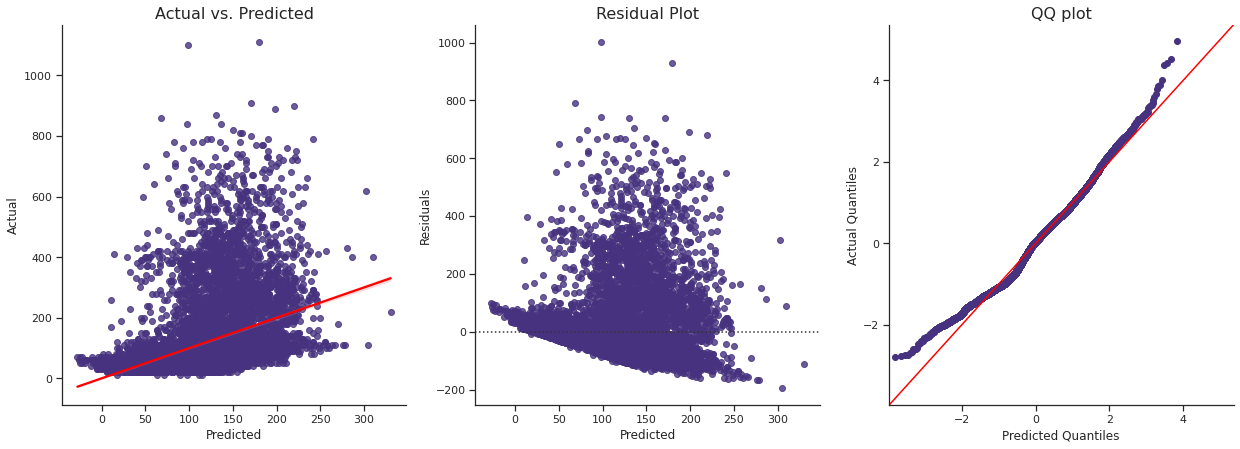

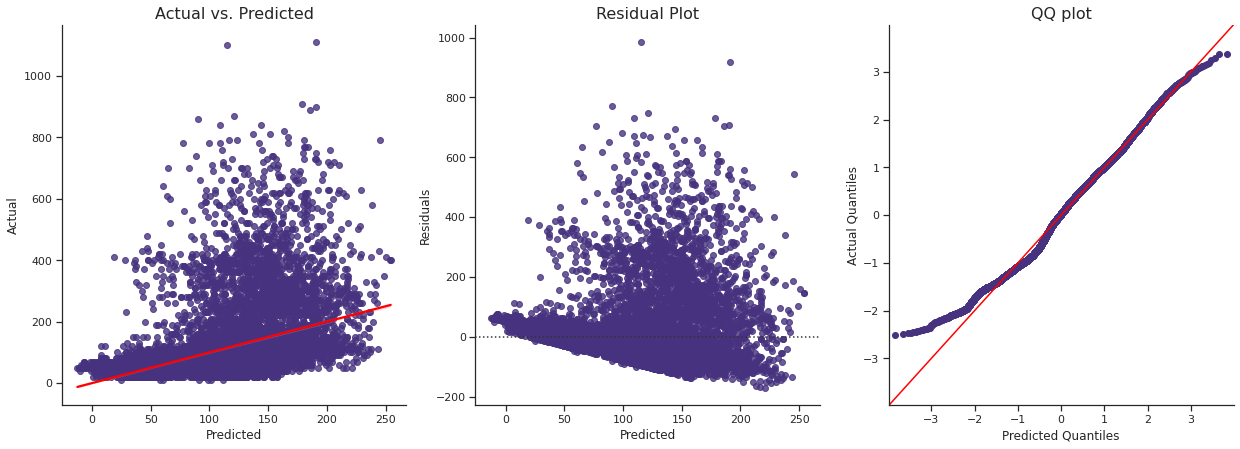

In [25]:
pt_pipeline.fit(X,y)
residual_plots(pt_pipeline, X, y)

qt_pipeline.fit(X,y)
residual_plots(qt_pipeline, X, y)

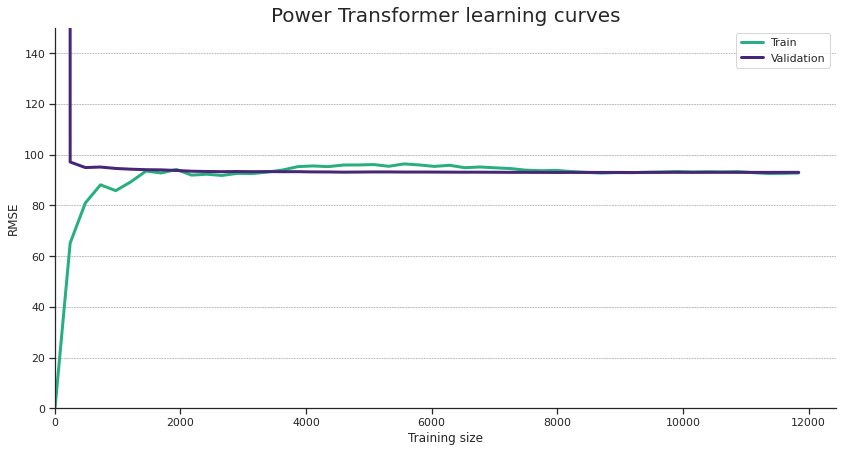

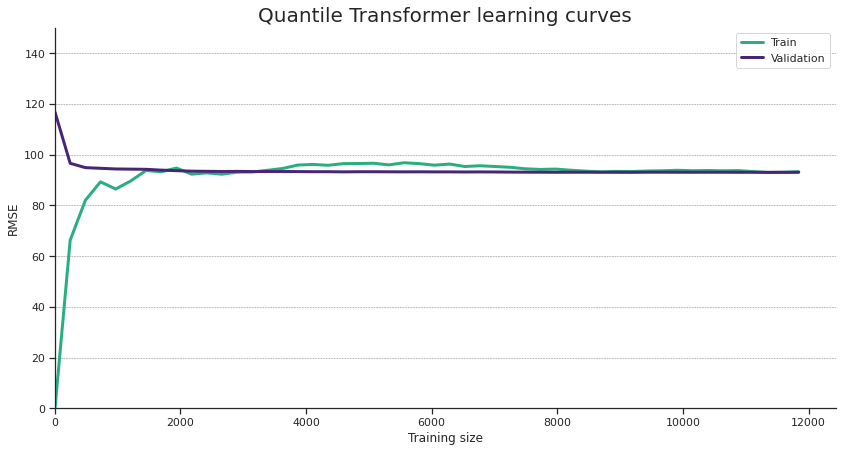

In [26]:
learning_curves(pt_pipeline, X, y, 'Power Transformer learning curves')
learning_curves(qt_pipeline, X, y, 'Quantile Transformer learning curves')

In [27]:
cv = cross_validate(pt_pipeline, X, y, cv=10, scoring=['neg_root_mean_squared_error', 'r2'])

mean_rmse = cv['test_neg_root_mean_squared_error'].mean()
mean_r2 = cv['test_r2'].mean()

cv_df.loc[cv_df.shape[0]] = (['power-transformer', mean_rmse, mean_r2])
cv_df

,model,average_rmse,average_r2
0,baseline,-92.508225,0.199379
1,transformed-target,-95.598424,0.145565
2,average-transform,-95.887430,0.139937
3,power-transformer,-92.868699,0.193183


In [28]:
print(f'average root mean squared error: {mean_rmse:.3f}')
print(f'average r squared: {mean_r2:.3f}')

average root mean squared error: -92.869
average r squared: 0.193


In [29]:
cv = cross_validate(qt_pipeline, X, y, cv=10, scoring=['neg_root_mean_squared_error', 'r2'])

mean_rmse = cv['test_neg_root_mean_squared_error'].mean()
mean_r2 = cv['test_r2'].mean()

cv_df.loc[cv_df.shape[0]] = (['quantile-transformer', mean_rmse, mean_r2])
cv_df

,model,average_rmse,average_r2
0,baseline,-92.508225,0.199379
1,transformed-target,-95.598424,0.145565
2,average-transform,-95.887430,0.139937
3,power-transformer,-92.868699,0.193183
4,quantile-transformer,-93.237549,0.186804


In [30]:
print(f'average root mean squared error: {mean_rmse:.3f}')
print(f'average r squared: {mean_r2:.3f}')

average root mean squared error: -93.238
average r squared: 0.187


Applying power and quantile transformations seems to be a better preprocessing step than ones tried earlier, however, it has not improved the RMSE performance of the baseline model. Comparing the residual and q-q plots is interesting, where the quantile transformation clusters data around the distribution means, and becomes worse at predicting values at the low and high extremes, indicating heavy kurtosis as a result of this transformation.

The learning curve for power transformer is the best seen so far, with a lower error rate for training and validation datasets, however, still not performing as well as the baseline model.

#### 3. Date Transformations
Maybe the date transformations are the issue, hoever, it is seeming more and more likely that the distribution is non-linear and a non-linear function is required. Simplifying the date transformation could be explored.

In [31]:
ct = (CyclicalTransformer(['date']), ['date'])
sdt = (SimpleDateTransformer(['date']), ['date'])

ct_preprocess = make_column_transformer(drop, ct, remainder='passthrough')
sdt_preprocess = make_column_transformer(drop, sdt, remainder='passthrough')

ct_pipeline = make_pipeline(ct_preprocess, ss, model)
sdt_pipeline = make_pipeline(sdt_preprocess, ss, model)

In [32]:
cv = cross_validate(ct_pipeline, X, y, cv=10, scoring=['neg_root_mean_squared_error', 'r2'])

mean_rmse = cv['test_neg_root_mean_squared_error'].mean()
mean_r2 = cv['test_r2'].mean()

cv_df.loc[cv_df.shape[0]] = (['cyclical-date-transformer', mean_rmse, mean_r2])
cv_df

,model,average_rmse,average_r2
0,baseline,-92.508225,0.199379
1,transformed-target,-95.598424,0.145565
2,average-transform,-95.887430,0.139937
3,power-transformer,-92.868699,0.193183
4,quantile-transformer,-93.237549,0.186804
5,cyclical-date-transformer,-92.213753,0.204461


In [33]:
print(f'average root mean squared error: {mean_rmse:.3f}')
print(f'average r squared: {mean_r2:.3f}')

average root mean squared error: -92.214
average r squared: 0.204


In [34]:
cv = cross_validate(sdt_pipeline, X, y, cv=10, scoring=['neg_root_mean_squared_error', 'r2'])

mean_rmse = cv['test_neg_root_mean_squared_error'].mean()
mean_r2 = cv['test_r2'].mean()

cv_df.loc[cv_df.shape[0]] = (['simple-date-transformer', mean_rmse, mean_r2])
cv_df

,model,average_rmse,average_r2
0,baseline,-92.508225,0.199379
1,transformed-target,-95.598424,0.145565
2,average-transform,-95.887430,0.139937
3,power-transformer,-92.868699,0.193183
4,quantile-transformer,-93.237549,0.186804
5,cyclical-date-transformer,-92.213753,0.204461
6,simple-date-transformer,-92.570806,0.198349


In [35]:
print(f'average root mean squared error: {mean_rmse:.3f}')
print(f'average r squared: {mean_r2:.3f}')

average root mean squared error: -92.571
average r squared: 0.198


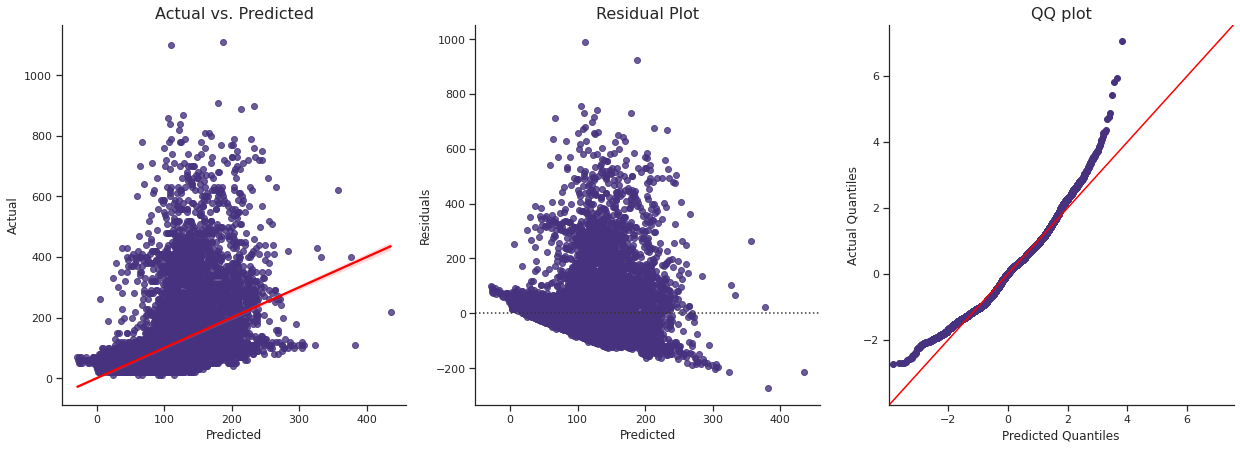

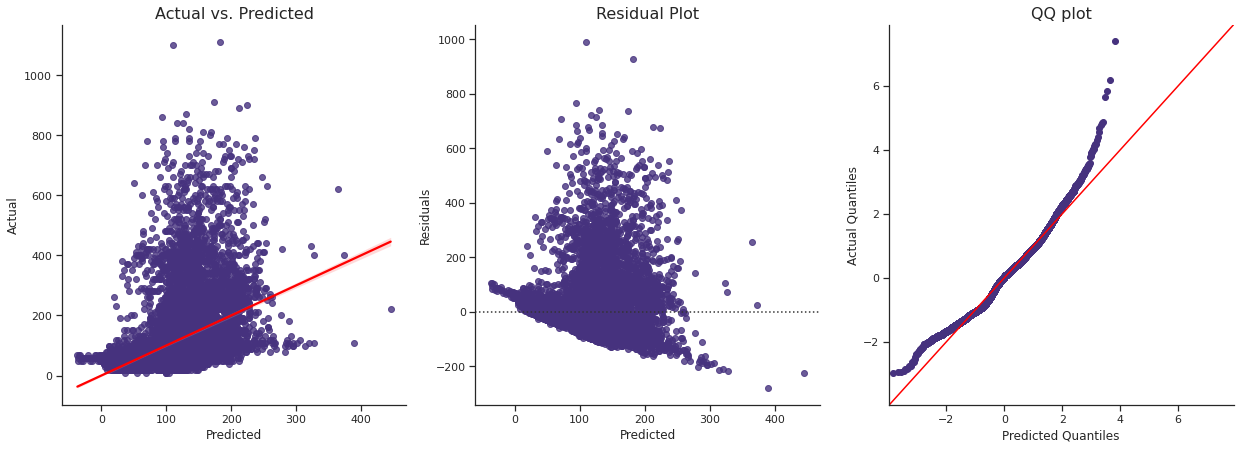

In [36]:
ct_pipeline.fit(X, y)
residual_plots(ct_pipeline, X, y)

sdt_pipeline.fit(X, y)
residual_plots(sdt_pipeline, X, y)

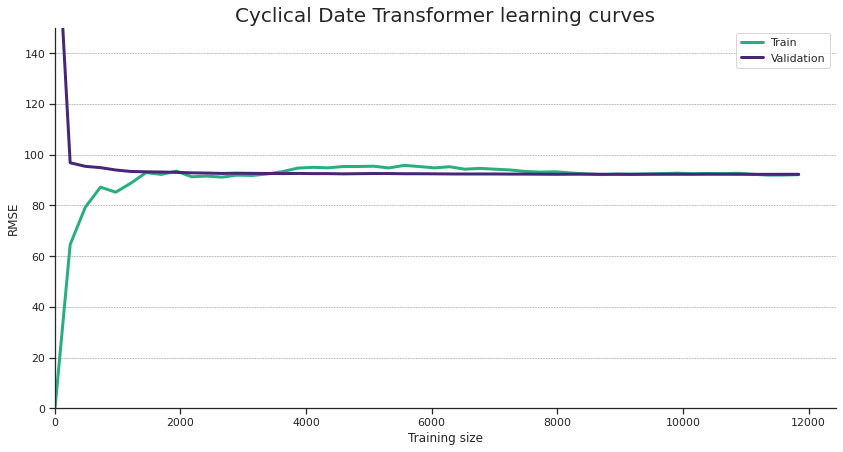

In [37]:
learning_curves(ct_pipeline, X, y, 'Cyclical Date Transformer learning curves')

The learning curve using the cyclical date transformer shows better optimsation of the loss metric than other models.

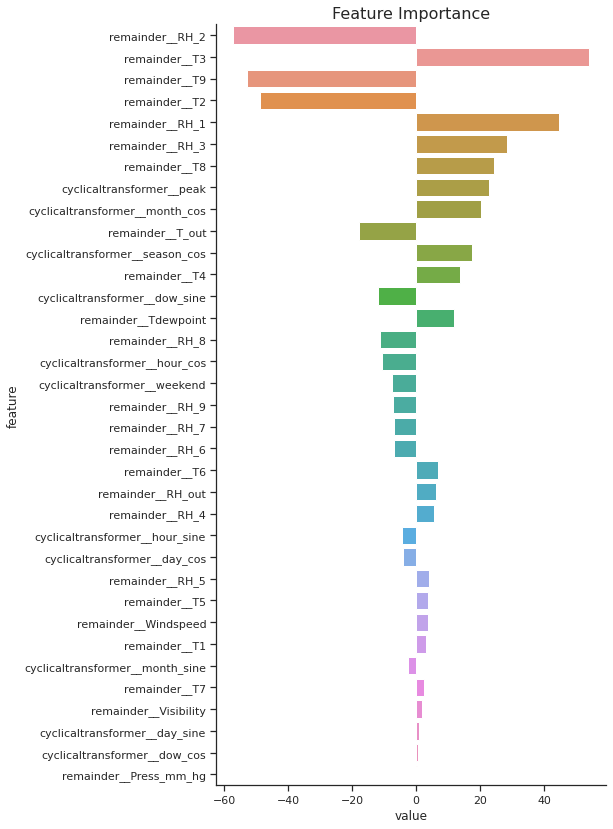

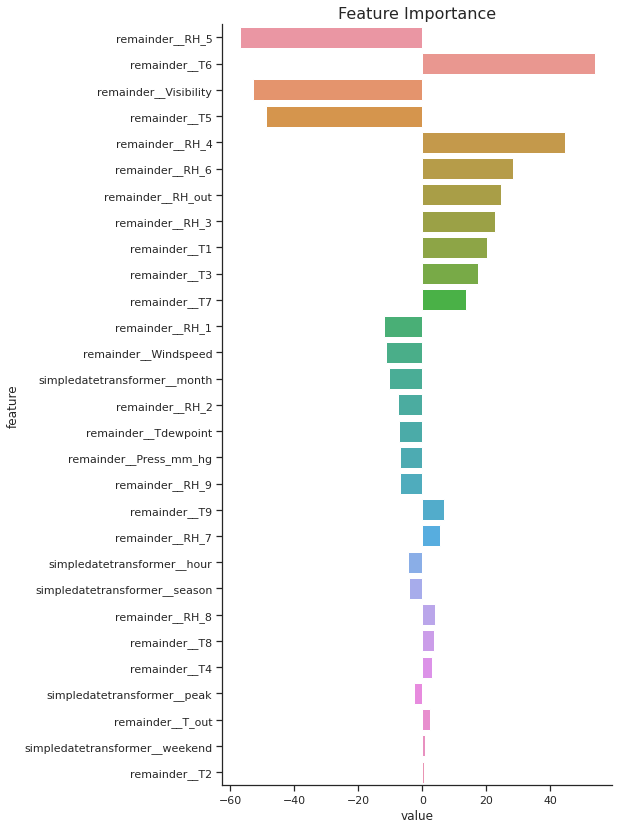

In [38]:
features =  ct_pipeline[:-2].get_feature_names_out()
feature_importance(ct_pipeline, features)

features =  sdt_pipeline[:-2].get_feature_names_out()
feature_importance(sdt_pipeline, features)

#### 4.Feature Selection
A final method for overcoming multicollinearity discovered in the exploratory steps and improve the performance of the linear regression model could be to use some kind of feature selection in order to reduce the noise of the input features. A Lasso regression model effectively nullifies the presence of unimportant features by reducing their coefficients.

In [39]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(Lasso())
fs_pipeline = make_pipeline(preprocess, sfm, model)
fs_pipeline.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['rv1', 'rv2']),
                                                 ('datetransformer',
                                                  DateTransformer(date=['date']),
                                                  ['date'])])),
                ('selectfrommodel', SelectFromModel(estimator=Lasso())),
                ('linearregression', LinearRegression())])

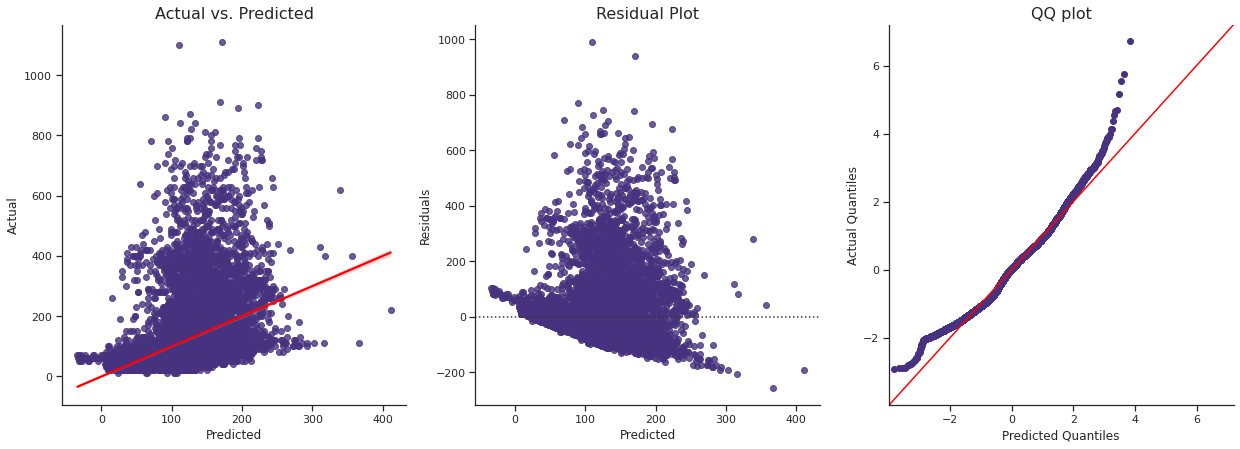

In [40]:
residual_plots(fs_pipeline, X, y)

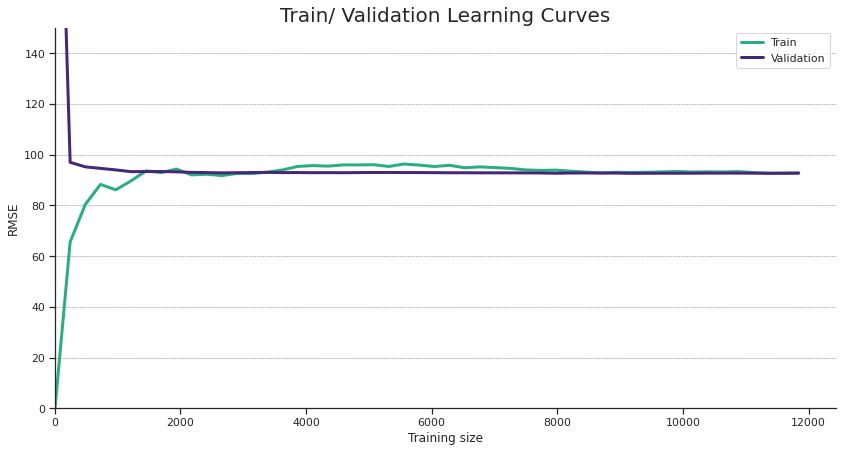

In [41]:
learning_curves(fs_pipeline, X, y)

Reducing features did not seem to improve the model. Another option to consider is a polynomial model to get that desired increase in complexity.

In [42]:
cv = cross_validate(fs_pipeline, X, y, cv=10, scoring=['neg_root_mean_squared_error', 'r2'])

mean_rmse = cv['test_neg_root_mean_squared_error'].mean()
mean_r2 = cv['test_r2'].mean()

cv_df.loc[cv_df.shape[0]] = (['lasso-feature-selection', mean_rmse, mean_r2])
cv_df

,model,average_rmse,average_r2
0,baseline,-92.508225,0.199379
1,transformed-target,-95.598424,0.145565
2,average-transform,-95.887430,0.139937
3,power-transformer,-92.868699,0.193183
4,quantile-transformer,-93.237549,0.186804
5,cyclical-date-transformer,-92.213753,0.204461
6,simple-date-transformer,-92.570806,0.198349
7,lasso-feature-selection,-92.784607,0.194641


In [43]:
print(f'average root mean squared error: {mean_rmse:.3f}')
print(f'average r squared: {mean_r2:.3f}')

average root mean squared error: -92.785
average r squared: 0.195


In [44]:
cv_df.sort_values(by='average_rmse', inplace=True, ascending=False)
cv_df

,model,average_rmse,average_r2
5,cyclical-date-transformer,-92.213753,0.204461
0,baseline,-92.508225,0.199379
6,simple-date-transformer,-92.570806,0.198349
7,lasso-feature-selection,-92.784607,0.194641
3,power-transformer,-92.868699,0.193183
4,quantile-transformer,-93.237549,0.186804
1,transformed-target,-95.598424,0.145565
2,average-transform,-95.887430,0.139937


## Hyperparameter Tuning
None of the preprocessing or transformation steps seemed to improve the model on their own, however, there is a chance that a blend of several features may result in an improvement. Scaling differences are the most of interest, after analysis the residual and q-q plots, power and quantile transformation may prove to be better options in other regression models.

In [45]:
hp_preprocess = make_column_transformer(drop, t_at, rh_at, dt, drop_t_rh, remainder='passthrough')
hp_pipeline = make_pipeline(hp_preprocess, ss, sfm, model)

params = [{
    'columntransformer__datetransformer': [DateTransformer(['date']), CyclicalTransformer(['date']), SimpleDateTransformer(['date'])],
    'columntransformer__averagetransformer-1':[t_at, 'passthrough'],
    'columntransformer__averagetransformer-2':[rh_at, 'passthrough'],
    'columntransformer__drop-2': [drop_t_rh, 'passthrough'],
    'standardscaler':[ss, pt, qt],
    'selectfrommodel':[sfm, 'passthrough']
}]

gs = GridSearchCV(hp_pipeline, params, scoring = {'rmse': rmse, 'r2': r2}, refit='rmse', n_jobs=-1)
gs.fit(X, y)

results = pd.DataFrame(gs.cv_results_)[['param_columntransformer__datetransformer', 'param_columntransformer__averagetransformer-1','param_columntransformer__averagetransformer-2', 'param_columntransformer__drop-2', 'param_standardscaler', 'param_selectfrommodel', 'mean_test_rmse', 'mean_test_r2']]
results.sort_values(by='mean_test_rmse', inplace=True, ascending=False)

results[:10]


,param_columntransformer__datetransformer,param_columntransformer__averagetransformer-1,param_columntransformer__averagetransformer-2,param_columntransformer__drop-2,param_standardscaler,param_selectfrommodel,mean_test_rmse,mean_test_r2
129,CyclicalTransformer(cyclical_features=['date']),passthrough,passthrough,passthrough,StandardScaler(),passthrough,-92.229119,0.204870
117,DateTransformer(date=['date']),passthrough,passthrough,passthrough,StandardScaler(),passthrough,-92.517533,0.199912
126,CyclicalTransformer(cyclical_features=['date']),passthrough,passthrough,passthrough,StandardScaler(),SelectFromModel(estimator=Lasso()),-92.579331,0.198949
141,SimpleDateTransformer(date=['date']),passthrough,passthrough,passthrough,StandardScaler(),passthrough,-92.586765,0.198745
130,CyclicalTransformer(cyclical_features=['date']),passthrough,passthrough,passthrough,PowerTransformer(),passthrough,-92.640665,0.197772
118,DateTransformer(date=['date']),passthrough,passthrough,passthrough,PowerTransformer(),passthrough,-92.889940,0.193473
138,SimpleDateTransformer(date=['date']),passthrough,passthrough,passthrough,StandardScaler(),SelectFromModel(estimator=Lasso()),-92.898011,0.193469
142,SimpleDateTransformer(date=['date']),passthrough,passthrough,passthrough,PowerTransformer(),passthrough,-92.968131,0.192148
131,CyclicalTransformer(cyclical_features=['date']),passthrough,passthrough,passthrough,QuantileTransformer(),passthrough,-92.991273,0.191673
127,CyclicalTransformer(cyclical_features=['date']),passthrough,passthrough,passthrough,PowerTransformer(),SelectFromModel(estimator=Lasso()),-92.996512,0.191681


In [46]:
lr_best = gs.best_estimator_

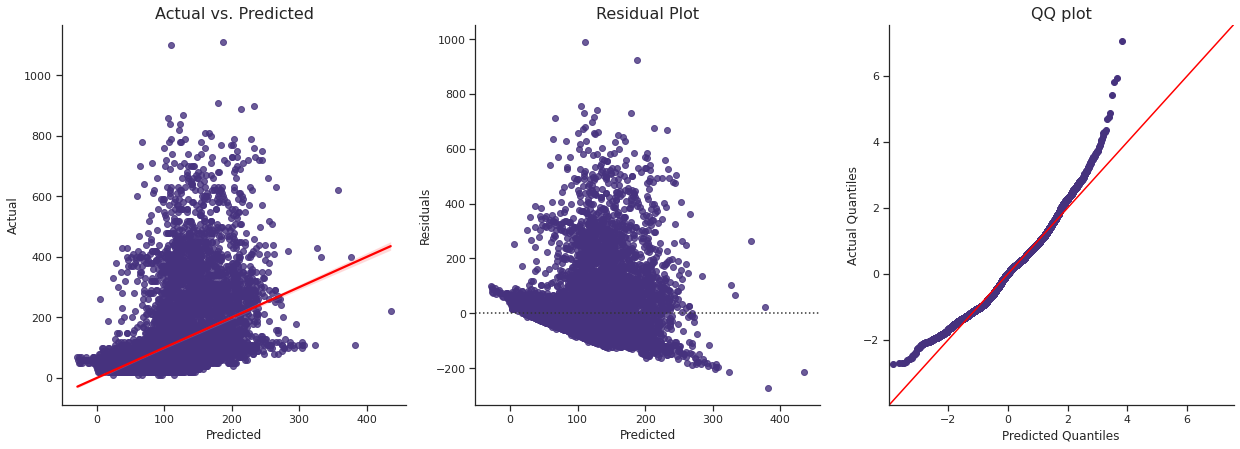

In [47]:
residual_plots(lr_best, X, y)

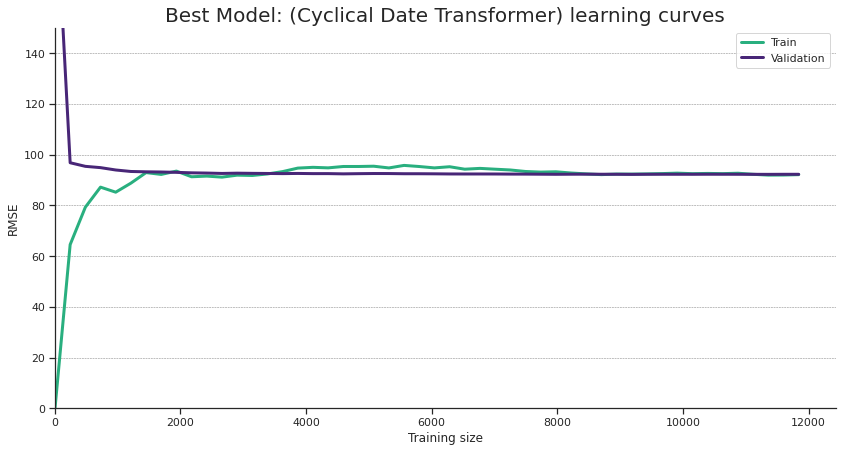

In [48]:
learning_curves(lr_best, X, y, 'Best Model: (Cyclical Date Transformer) learning curves')

In [49]:
cv_df.sort_values(by='average_rmse', ascending=False)

,model,average_rmse,average_r2
5,cyclical-date-transformer,-92.213753,0.204461
0,baseline,-92.508225,0.199379
6,simple-date-transformer,-92.570806,0.198349
7,lasso-feature-selection,-92.784607,0.194641
3,power-transformer,-92.868699,0.193183
4,quantile-transformer,-93.237549,0.186804
1,transformed-target,-95.598424,0.145565
2,average-transform,-95.887430,0.139937


## Evaluation 
It seems that the cyclical date transformer performed best, slightly edging the baseline model. It is clear that linear regression is not the right approach for predicting the target feature of this dataset.

In [50]:
filename = 'models/lr_best.sav'
joblib.dump(lr_best, filename)

['models/lr_best.sav']